In [1]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import math


import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

3.5.2
Welcome to JupyROOT 6.14/08


In [2]:
# now add in Laurens functions
def getSpecList(hist_list):

    ## Function that concatenates a list of TH1Ds into a python list
    ## Inputs:
    ##   hist_list    list of spectra to be concatenated (python list of TH1Ds)
    ## Returns:
    ##   spec         concatenated spectrum (python list)

    # Initilize output spectrum
    spec = []

    # Loop over input spectra...
    for hist in hist_list:
        # Loop over bins in this spectrum...
        for i in range(hist.GetNbinsX()):
            spec.append( hist.GetBinContent(i+1) )

    # Return concatenated spectrum
    return spec
## End definition of getSpecList

def getSpecHist(spec, in_hist):

    ## Function that converts a spectrum into a TH1D
    ## Inputs:
    ##   spec       input spectrum (python list)
    ##   in_hist    histogram to use as a template for the output (TH1D)
    ## Returns:
    ##   out_hist   input spectrum as TH1D

    # Initilize output spectrum histogram, as a copy of in_hist
    out_hist = ROOT.TH1D(in_hist)

    # Loop over input spectrum...
    for i in range(len(spec)):
        out_hist.SetBinContent(i+1, spec[i])
        out_hist.SetBinError(i+1, 0.)

    # Return spectrum histogram
    return out_hist
## End definition of getSpecList

In [3]:
def getFullCovar(frac_covar, spec, debug=False):

    ## Function that calcuates full covariance matrix
    ## Inputs:
    ##   frac_covar    fractional covariance matrix (TMatrixD)
    ##   spec          spectrum (python list or similar)
    ##   debug         flag for whether to print out various debugging information
    ## Returns:
    ##   full_covar    full covariance matrix (TMatrixD)

    # If in debug mode, print out information on inputs
    if debug:
        print("spectrum: ", spec)
        print("fractional covariance matrix: ")
        print(frac_covar[0][0])
        frac_covar.Print()

    # Initialize output full covariance matrix as a copy of input fractional covariance matrix
    full_covar = ROOT.TMatrixD(frac_covar)

    # Compute M_ij = F_ij*N_i*N_j
    for i in range(full_covar.GetNrows()):
        for j in range(full_covar.GetNcols()):
            if math.isnan(full_covar[i][j]):
                full_covar[i][j] = 0.
            else:
                full_covar[i][j] *= spec[i]*spec[j]

    # If in debug mode, print out information on output
    if debug:
        print("full covariance matrix: ")
        print(full_covar[0][0])
        full_covar.Print()

    # Return full covariance matrix
    return full_covar
## End definition of getFullCovar

def getFracCovar(full_covar, spec, debug=False):

    ## Function that calcuates fractional covariance matrix
    ## Inputs:
    ##   full_covar    full covariance matrix (TMatrixD)
    ##   spec          spectrum (python list or similar)
    ##   debug         flag for whether to print out various debugging information
    ## Returns:
    ##   frac_covar    fractional covariance matrix (TMatrixD)

    # If in debug mode, print out information on inputs
    if debug:
        print("spectrum: ", spec)
        print("full covariance matrix: ")
        print(full_covar[0][0])
        full_covar.Print()

    # Initialize output fractional covariance matrix as a copy of input full covariance matrix
    frac_covar = ROOT.TMatrixD(full_covar)

    # Compute F_ij = M_ij/(N_i*N_j)
    for i in range(full_covar.GetNrows()):
        for j in range(full_covar.GetNcols()):
            if spec[i]*spec[j] == 0.:
                frac_covar[i][j] = float('nan')
            else:
                frac_covar[i][j] *= 1./(spec[i]*spec[j])

    # If in debug mode, print out information on output
    if debug:
        print("fractional covariance matrix: ")
        print(frac_covar[0][0])
        frac_covar.Print()

    # Return fractional covariance matrix
    return frac_covar
## End definition of getFracCovar

def checkInversion(matrix, inverse, tol=1e-6, debug=False):

    # Make copies of the matrices
    mat = ROOT.TMatrixD(matrix)
    inv = ROOT.TMatrixD(inverse)

    # Compute check1 = matrix * inverse
    check1 = ROOT.TMatrixD(mat)
    check1 *= inv

    # Compute check2 = inverse * covar
    check2 = ROOT.TMatrixD(inv)
    check2 *= mat

    # If in debug mode, print resulting matrices
    if debug:
        print("covar * inverse matrix: ")
        check1.Print()
        print("inverse * covar matrix: ")
        check2.Print()

    # For both check1 and check2, check that diagonal entries are nearly 1 and off-diagonal entries are nearly zero
    dim = mat.GetNrows()  # dimension of the matrix
    #tol = 1e-6           # tolerance for deviations from identity matrix, passed as an argument instead
    for i in range(dim):
        for j in range(dim):
            # Diagonal entries...
            if i == j:
                if ( abs(check1[i][j]-1) < tol ) and ( abs(check2[i][j]-1) < tol ): continue
                else: return False
            # Off-diagonal entries...
            else:
                if ( abs(check1[i][j]) < tol ) and ( abs(check2[i][j]) < tol): continue
                else: return False

    return True
## End definition of checkInversion



In [4]:
def runConstraint(nue_spec, numu_spec, covar, numu_data_spec, debug=False):

    ## Function that calculates constrained nue prediction and covariance matrix using the method from docdb-32672
    ## Inputs:
    ##   nue_spec             nue MC spectrum (python list or similar)
    ##   numu_spec            numu MC spectrum (python list or similar)
    ##   covar                joint nue+numu total covariance marix (TMatrixD)
    ##                          note: this should include all systematic uncertainties and MC stat errors, but *not* data stat errors
    ##                          note: this should be the full/absolute covariance matrix, *not* fractional
    ##   numu_data_spec       numu data spectrum (python list or similar)
    ##   debug                flag for whether to print out various debugging information
    ## Returns:
    ##   constr_nue_spec      constrained nue spectrum (python list)
    ##   constr_nue_covar     constrained nue covariance matrix (TMatrixD)
    ##                          note: *not* fractional, same as input covar


    # If operating in debug mode, print out information on inputs
    if debug:
        print("nue spectrum: ", nue_spec)
        print("numu spectrum: ", numu_spec)
        print("numu data spectrum: ", numu_data_spec)
        print("covariance matrix: ")
        covar.Print()

    # Count the number of bins in each spectrum
    Nbins_e = len(nue_spec)
    Nbins_m = len(numu_spec)
    # Check that the dimensions of the inputs are consistent
    if len(numu_data_spec) != Nbins_m:
        print("Length of numu data spec doesn't match numu spec! returning...")
        return
    if covar.GetNrows() != Nbins_e+Nbins_m:
        print("Dimension of covariance matrix doesn't match nue+numu spec! returning...")
        return
    # If in debug mode, pring out the number of bins in each spectrum
    if debug:
        print("nue spectrum bins: ", Nbins_e)
        print("numu spectrum bins: ", Nbins_m)
        
    # Take the standard covariance matrix and break it into its block components
    covar_ee = ROOT.TMatrixD(Nbins_e,Nbins_e)
    for i in range(Nbins_e):
        for j in range(Nbins_e):
            covar_ee[i][j] = covar[i][j]
    covar_em = ROOT.TMatrixD(Nbins_e,Nbins_m)
    covar_me = ROOT.TMatrixD(Nbins_m,Nbins_e)
    for i in range(Nbins_e):
        for j in range(Nbins_m):
            covar_em[i][j] = covar[i][Nbins_e+j]
            covar_me[j][i] = covar[i][Nbins_e+j]
    covar_mm = ROOT.TMatrixD(Nbins_m,Nbins_m)
    for i in range(Nbins_m):
        for j in range(Nbins_m):
            covar_mm[i][j] = covar[Nbins_e+i][Nbins_e+j]
    # If in debug mode, print these matrices and their first diagonal elements
    if debug:
        print("covariance matrix ee: ")
        print(covar_ee[0][0])
        covar_ee.Print()
        print("covariance matrix em: ")
        print(covar_em[0][0])
        covar_em.Print()
        print("covariance matrix me: ")
        print(covar_me[0][0])
        covar_me.Print()
        print("covariance matrix mm: ")
        print(covar_mm[0][0])
        covar_mm.Print()

    # Add the predicted data statistical errors to covar_mm
    for i in range(Nbins_m):
        covar_mm[i][i] += numu_spec[i]
    # If in debug mode, print this matrix and its first diagonal element
    if debug:
        print("covariance matrix mm, with expected data statistical errors added:")
        print(covar_mm[0][0])
        covar_mm.Print()
        
    # Compute the constrained nue prediction as mu_e^{constrained} = mu_e + covar_em*(covar_mm)^{-1}*(X_m - mu_m)...
    #   where mu are the predicted spectra (N^{MC}), X are the observed spectra (N^{data}), and the covar are the blocks of the covariance matrix as defined above
    diff_vec = ROOT.TMatrixD(Nbins_m,1)  # diff_vec = X_m - mu_m
    for i in range(Nbins_m):
        diff_vec[i][0] = numu_data_spec[i] - numu_spec[i]
    covar_mm_inverse = ROOT.TMatrixD(covar_mm).Invert()
    if not checkInversion(covar_mm, covar_mm_inverse):
        print("Matrix covar_mm not invertable, returning...")
        return
    calc_vec1 = ROOT.TMatrixD(Nbins_m,1)  # calc_vec1 = (covar_mm)^{-1}*diff_vec
    #calc_vec1 = ROOT.TMatrixD.Mult(covar_mm_inverse, diff_vec)
    for i in range(Nbins_m):
        calc_vec1[i][0] = 0.
        for j in range(Nbins_m):
            calc_vec1[i][0] += covar_mm_inverse[i][j]*diff_vec[j][0]
    calc_vec2 = ROOT.TMatrixD(Nbins_e,1)   # calc_vec2 = covar_em*(covar_mm)^{-1}*diff_vec = covar_em*calc_vec1
    #calc_vec2 = ROOT.TMatrixD.Mult(covar_em, calc_vec1)
    for i in range(Nbins_e):
        calc_vec2[i][0] = 0.
        for j in range(Nbins_m):
            calc_vec2[i][0] += covar_em[i][j]*calc_vec1[j][0]
    constr_nue_spec = [ 0. for i in range(Nbins_e) ]
    for i in range(Nbins_e):
        constr_nue_spec[i] = nue_spec[i] + calc_vec2[i][0]
    # If in debug mode, print these matrices/vectors out...
    if debug:
        print("diff vec: ")
        diff_vec.Print()
        print("inverse of covar_mm: ")
        covar_mm_inverse.Print()
        print("(inverse of covar_mm)*diff_vec vec: ")
        calc_vec1.Print()
        print("covar_em*(inverse of covar_mm)*diff_vec vec:")
        calc_vec2.Print()
        print("constrained nue prediction: ")
        print(constr_nue_spec)
        
    # Compute the constrained nue covariance matrix as covar_ee^{constrained} = covar_ee - covar_em*(covar_mm)^{-1}*covar_me
    calc_mat1 = ROOT.TMatrixD(Nbins_m,Nbins_e)  # calc_mat1 = (covar_mm)^{-1}*covar_me
    #calc_mat1 = ROOT.TMatrixD.Mult(covar_mm_inverse, covar_me)
    for i in range(Nbins_m):
        for j in range(Nbins_e):
            calc_mat1[i][j] = 0.
            for k in range(Nbins_m):
                calc_mat1[i][j] += covar_mm_inverse[i][k]*covar_me[k][j]
    calc_mat2 = ROOT.TMatrixD(Nbins_e,Nbins_e)   # calc_mat2 = covar_em*(covar_mm)^{-1}*covar_me
    #calc_mat2 = ROOT.TMatrixD.Mult(covar_em, calc_mat1)
    for i in range(Nbins_e):
        for j in range(Nbins_e):
            calc_mat2[i][j] = 0.
            for k in range(Nbins_m):
                calc_mat2[i][j] += covar_em[i][k]*calc_mat1[k][j]
    constr_nue_covar = ROOT.TMatrixD(Nbins_e,Nbins_e)
    for i in range(Nbins_e):
        for j in range(Nbins_e):
            constr_nue_covar[i][j] = covar_ee[i][j] - calc_mat2[i][j]
    # If in debug mode, print these matrices out
    if debug:
        print("covar_em*(covar_mm)^{-1}*covar_me: ")
        calc_mat2.Print()
        print("constrained nue covariance matrix: ")
        constr_nue_covar.Print()

    # Return constrained prediction, covariance matrix
    return constr_nue_spec, constr_nue_covar
## End definition of runConstraint

In [5]:
# # Lauren's executable
# # If this is the executable...
# if __name__ == "__main__":

#     # Declare file names for input files
#     topdir = os.getcwd()
#     tag = "total"
#     in_h0_spec_fname = os.path.join(topdir, "leeless_{}.SBNspec.root".format(tag))
#     in_h1_spec_fname = os.path.join(topdir, "sens_{}.SBNspec.root".format(tag))
#     in_covar_fname   = os.path.join(topdir, "sens_{}.SBNcovar.root".format(tag))
#     # If "total" not in file names, throw an error
#     if "total" not in in_covar_fname:
#         print("Input file names must have 'total' in them! Exiting...")
#         sys.exit(1)

#     # Define helper variables...
#     #   Note: Making some assumptions about the xml configuration
#     Nbins_1e1p = 10
#     sel1e1p_keys = ["nu_uBooNE_1e1p_nue", "nu_uBooNE_1e1p_bnb", "nu_uBooNE_1e1p_lee"]
#     joint_keys   = ["nu_uBooNE_1e1p_nue", "nu_uBooNE_1e1p_bnb", "nu_uBooNE_1e1p_lee", "nu_uBooNE_1mu1p_bnb"]
#     # If we want debugging info, set this to True
#     debug = False


#     # Open the input files
#     in_h0_spec_f   = ROOT.TFile.Open(in_h0_spec_fname, "READ")
#     in_h1_spec_f   = ROOT.TFile.Open(in_h1_spec_fname, "READ")
#     in_covar_f     = ROOT.TFile.Open(in_covar_fname, "READ")
#     in_data_spec_f = in_h0_spec_f  # TODO: when real 1mu1p data is available, update this

#     # Declare file names for output files
#     out_h0_spec_fname = in_h0_spec_fname.replace("total", "constr")
#     out_h1_spec_fname = in_h1_spec_fname.replace("total", "constr")
#     out_covar_fname   = in_covar_fname.replace("total", "constr")

#     # Create the output files
#     out_h0_spec_f = ROOT.TFile(out_h0_spec_fname, "RECREATE")
#     out_h1_spec_f = ROOT.TFile(out_h1_spec_fname, "RECREATE")
#     out_covar_f   = ROOT.TFile(out_covar_fname, "RECREATE")


#     # Convert input spectra from TH1Ds to python lists
#     sel1e1p_spec  = getSpecList( [ in_h1_spec_f.Get(k) for k in sel1e1p_keys ] )
#     sel1mu1p_spec = getSpecList( [ in_h1_spec_f.Get("nu_uBooNE_1mu1p_bnb") ] )
#     joint_spec    = getSpecList( [ in_h1_spec_f.Get(k) for k in joint_keys ] )
#     sel1mu1p_data_spec = getSpecList( [ in_data_spec_f.Get("nu_uBooNE_1mu1p_bnb") ] )
#     # Convert input fractional covariance matrix to full covariance matrix
#     full_covar = getFullCovar( in_covar_f.Get("frac_covariance"), joint_spec, debug=debug )
    
#      # Run the constraint
#     constr_1e1p_spec, constr_1e1p_full_covar = runConstraint(sel1e1p_spec, sel1mu1p_spec, full_covar, sel1mu1p_data_spec, debug=debug)

#     # Convert the constrained spectra back to TH1Ds
#     out_h0_hist_dict = {}
#     out_h1_hist_dict = {}
#     for i in range(len(sel1e1p_keys)):
#         # Get the key
#         key = sel1e1p_keys[i]
#         # Get the corresponding portion of the constrained 1e1p spectrum
#         out_h1_list = constr_1e1p_spec[ i*Nbins_1e1p : (i+1)*Nbins_1e1p ]
#         if 'lee' not in key:
#             out_h0_list = out_h1_list
#         else:
#             out_h0_list = [ 0. for N in out_h1_list ]
#         # Fill output TH1Ds based on the results of the constraint procedure
#         out_h0_hist_dict[key] = getSpecHist( out_h0_list, in_h0_spec_f.Get(key) )
#         out_h1_hist_dict[key] = getSpecHist( out_h1_list, in_h1_spec_f.Get(key) )
#     # Convert the constrained full covariance matrix to a fractional covariance matrix
#     constr_1e1p_frac_covar = getFracCovar( constr_1e1p_full_covar, constr_1e1p_spec, debug=debug )


#     # Write everything out
#     for key in sel1e1p_keys:
#         out_h0_spec_f.WriteTObject(out_h0_hist_dict[key])
#         out_h1_spec_f.WriteTObject(out_h1_hist_dict[key])
#     out_covar_f.WriteTObject(constr_1e1p_frac_covar, "frac_covariance")
#     # Close the outputs
#     out_h0_spec_f.Close()
#     out_h1_spec_f.Close()
#     out_covar_f.Close()
#     # Close the inputs
#     in_h0_spec_f.Close()
#     in_h1_spec_f.Close()
#     in_covar_f.Close()
#     in_data_spec_f.Close()

#     print("Done!")
    
    

In [6]:
# Make the plot...
def plotCovar(covar, bins, tag1, tag2):
    ## Function that plots covariance matrices
    ## Inputs:
    ##   covar    covariance matrix, either full or fractional (TMatrixD)
    ##   bins     number of bins in each channel (python list or similar)
    ##   tag1     tag for type of covariance matrix, e.g. "Full" or "Fractional"
    ##   tag2     tag for contents of covarinace matrix, e.g. "Flux"
    
    # Unpack the covariance matrix into an array
    x = []
    for i in range(covar.GetNrows()):
        x.append([])
        for j in range(covar.GetNcols()):
            x[i].append(covar[i][j])
    # Plot that array
    plt.imshow(x, cmap='viridis', origin='lower')
    # Add vertical lines
    #   TODO: extend to work with sub-channels...
    Nbins_tot = sum(bins)
    for chan_i in range(len(bins)-1):
        chan_end = sum(bins[:chan_i+1])
        plt.hlines(chan_end-0.5, -0.5, Nbins_tot-0.5, colors='red')
        plt.vlines(chan_end-0.5, -0.5, Nbins_tot-0.5, colors='red')
    plt.colorbar()
    plt.xlabel('Global Bin Number')
    plt.ylabel('Global Bin Number')
    plt.title('{} Covariance Matrix, {}'.format(tag1, tag2))
    
    plt.rc('savefig', dpi=300)
    plt.savefig('covar_{}_{}.png'.format(tag1, tag2.replace(' ', '-')), bbox_inches='tight')
    plt.show()

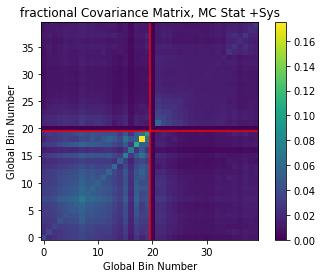

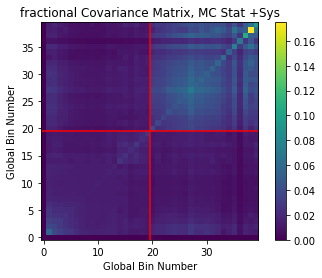

52


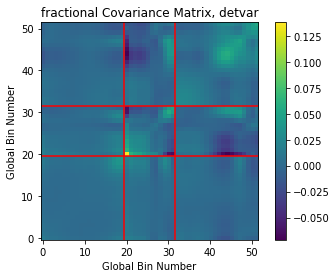

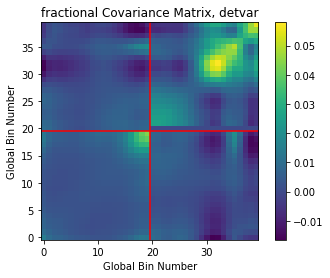

In [7]:
# first load in Lauren + ran's cov matrices into  root TMatrixD with 1mu1p in bottom left, pi0 in top right
nbins_mu = 20
nbins_pi0 = 20

# Flux + cross sec +MC stat from Lauren:
in_covar_f = ROOT.TFile.Open("../data/forKatie_withMCStat.SBNcovar.root", "READ")
lsys_cov = in_covar_f.Get("frac_covariance")

# plot input form - still need to move around to my form
plotCovar(lsys_cov, [20,20], "fractional", "MC Stat +Sys")

# move everything by hand 
# make copy of input
lsys_cov_switched = ROOT.TMatrixD(lsys_cov)
for i in range(nbins_mu+nbins_pi0):
    for j in range (nbins_mu+nbins_pi0):
#         get value of original
        origval = lsys_cov[i][j]
        if (i<20 and j<20):
            lsys_cov_switched[i+20][j+20]=origval
        elif (i>=20 and j>=20):
            lsys_cov_switched[i-20][j-20]=origval
        elif (i<20 and j>=20):
            lsys_cov_switched[i+20][j-20]=origval
        elif (i>=20 and j<20):
            lsys_cov_switched[i-20][j+20]=origval

# plot new version of Laurens to make sure pieces moved properly
plotCovar(lsys_cov_switched, [20,20], "fractional", "MC Stat +Sys")

# load in csv version from ran
import pandas as pd 
in_detvar_f = np.nan_to_num(np.genfromtxt("../data/covMat_Tot.csv",delimiter=','))
print(len(in_detvar_f))
# put in TMatrixD
rdet_cov = ROOT.TMatrixD(52,52)
for i in range(52):
    for j in range(52):
        origval  = in_detvar_f[i][j]
        rdet_cov[i][j]=origval

# plot to check original version
plotCovar(rdet_cov, [20,12,20], "fractional", "detvar")


# change format of detvar
rdet_cov_switched = ROOT.TMatrixD(40,40)
for i in range(52):
    for j in range(52):
        origval  = rdet_cov[i][j]
        if (i==j and origval==0): 
            origval=1.0
        #keep bottom corner where it is
        if (i<20 and j<20):
            rdet_cov_switched[i][j]=origval
        #bottomright
        elif (i>=32 and j<20):
            rdet_cov_switched[i-12][j]=origval
        #topleft
        elif (i<20 and j>=32):
            rdet_cov_switched[i][j-12]=origval
        #topright
        elif (i>32 and j>=32):
            rdet_cov_switched[i-12][j-12]=origval
        

# plot new version of Laurens to make sure pieces moved properly
plotCovar(rdet_cov_switched, [20,20], "fractional", "detvar")

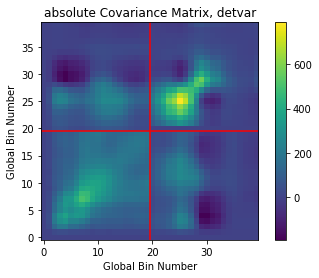

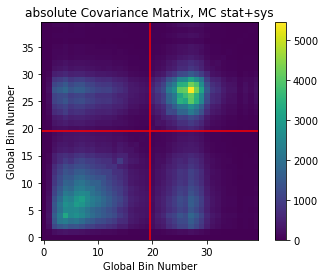

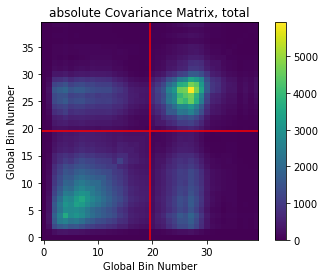

In [8]:
# now make a total cov matrix to feed into constraint
# need nu-only spectra, extbnb only spectra, and total spectra

pi0_nu=[47.117627448234586, 70.33873243614818, 97.63130750879412, 140.73932352853038, 170.88819438274447, 236.6686027974058, 246.10844757434342, 260.2470159715978, 256.70775776976325, 182.58945959384718, 95.72462997887123, 56.09886196174314, 47.130430195730824, 33.13246481561536, 24.365081153458775, 19.273660080235395, 11.609852448779272, 13.119085674046291, 10.70942173832437, 18.61509556203697]
pi0_extbnb=[13.840030449156185, 17.568513285000126, 13.57155522560129, 24.741918586170843, 18.62732903225742, 28.470401422014792, 15.972747090633046, 13.034604778491506, 9.574597166202462, 12.512739478344, 7.978830971835386, 3.4600076122890466, 5.324249030211016, 5.0557738066561235, 7.188490448132985, 1.5957661943670773, 6.6515400010232, 1.5957661943670773, 1.5957661943670773, 1.5957661943670773]
pi0_total=[60.957657897390774, 87.9072457211483, 111.20286273439541, 165.48124211470122, 189.5155234150019, 265.1390042194206, 262.08119466497646, 273.2816207500893, 266.2823549359657, 195.10219907219118, 103.70346095070661, 59.55886957403219, 52.45467922594184, 38.188238622271484, 31.55357160159176, 20.86942627460247, 18.26139244980247, 14.71485186841337, 12.305187932691446, 20.210861756404046]

mu_nu=[0.0, 29.447746755497604, 173.47235228190877, 263.76164164125385, 343.2253662429369, 335.705110428949, 410.4444290045592, 432.404040682125, 391.0830192322167, 368.6424530587898, 326.02671432515626, 295.60956978579253, 257.2436965943346, 213.62792631566435, 188.40836685605416, 142.2785517245076, 107.01720293900642, 84.38812325322387, 71.75295431752139, 64.35271652580774 ]
mu_extbnb=[0.0, 0.0, 6.605342230213832, 4.980228112994617, 18.19091257342228, 4.980228112994617, 0.0, 6.605342230213832, 16.513355575534582, 0.0, 8.282899228101533, 9.908013345320748, 0.0, 6.605342230213832, 3.3551139957754006, 1.6775569978877003, 6.605342230213832, 0.0, 0.0, 0.0]
mu_total=[0.0, 29.447746755497604, 180.0776945121226, 268.74186975424846, 361.4162788163592, 340.6853385419436, 410.4444290045592, 439.0093829123388, 407.5963748077513, 368.6424530587898, 334.30961355325775, 305.51758313111327, 257.2436965943346, 220.2332685458782, 191.76348085182957, 143.9561087223953, 113.62254516922026, 84.38812325322387, 71.75295431752139, 64.35271652580774 ]
mu_data = [0.0, 23.0, 188.0, 273.0, 415.0, 392.0, 471.0, 444.0, 489.0, 394.0, 357.0, 303.0, 236.0, 238.0, 185.0, 124.0, 114.0, 112.0, 81.0, 61.0]

# multiply Ran’s covariance matrix by the nu-only spectra to get an “absolute” (non-fractional) detector systematics covariance matri
full_det = ROOT.TMatrixD(40,40)
detspec =[]
for i in range(len(mu_nu)):
    detspec.append(mu_nu[i])
for i in range(len(pi0_nu)):
    detspec.append(pi0_nu[i])
full_det = getFullCovar(rdet_cov_switched, detspec, debug=False)
# plot to check
plotCovar(full_det , [20,20], "absolute", "detvar")

# multiply my covariance matrix by the total (nu+EXTBNB) spectra to get an absolute everything-else covariance matrix
full_sys = ROOT.TMatrixD(40,40)
sysspec =[]
for i in range(len(mu_total)):
    sysspec.append(mu_total[i])
for i in range(len(pi0_total)):
    sysspec.append(pi0_total[i])
full_sys = getFullCovar(lsys_cov_switched, sysspec, debug=False)
# plot to check
plotCovar(full_sys , [20,20], "absolute", "MC stat+sys")

# add those covariance matrices together in their “absolute” (non-fractional) form and then feed that into the constraint procedure
total_cov = ROOT.TMatrixD(40,40)
for i in range(40):
    for j in range(40):
        total_cov[i][j] = full_sys[i][j]+full_det[i][j]
plotCovar(total_cov , [20,20], "absolute", "total")

[30.0, 43.5, 57.0, 70.5, 84.0, 97.5, 111.0, 124.5, 138.0, 151.5, 165.0, 178.5, 192.0, 205.5, 219.0, 232.5, 246.0, 259.5, 273.0, 286.5]


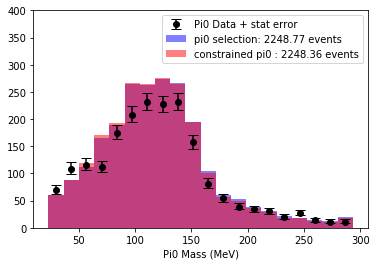

In [10]:
# now feed the covariance matrix into the constraint code

constr_pi0_spec, constr_full_covar = runConstraint(pi0_total, mu_total, total_cov, mu_data)

# make result plot:
xbins = [30+i*(270.0/20.0) for i in range(20)]
print(xbins)
width = (270.0/20.0)     # gives histogram aspect to the bar diagram
pi0_data=[70,109,116,112,175,208,231,227,231,157,81,54,39,34,30,20,27,14,11,11]
elow=[7.411426752061871, 9.477339820756967, 9.806399527108852, 9.619613792340374, 12.259165590485082, 13.450565982071538, 14.225887450926592, 14.093911076112732, 14.225887450926592, 11.561755207254379, 8.042065898387975, 6.3987259821433895, 5.3031236995310636, 4.892789355090201, 4.5426723380478435, 3.5508915136007886, 4.2648124469215105, 2.8344512197648175, 2.420325375653885, 2.420325375653885]
ehigh=[9.401665051278542, 11.467503657646105, 11.79655529399362, 11.60977400730313, 14.24927877315372, 15.440665912367706, 16.21598030537109, 16.084005064940243, 16.21598030537109, 13.551878069740411, 10.032276025530223, 8.389025126422816, 7.293524999317732, 6.883244181033419, 6.533182483701786, 5.541633228686699, 6.255374294019077, 4.825480768265262, 4.411610206727735, 4.411610206727735]
ax = plt.axes()
# ax.set_xticks(xbins+width / 2.0)
# ax.set_xticklabels(xbins)
ax.set_xlabel("Pi0 Mass (MeV)")
plt.ylim(0,400)
plt.errorbar(xbins,pi0_data, yerr=(elow,ehigh),fmt='o', color = 'black', ecolor='black', capsize=5,label = 'Pi0 Data + stat error')
# plt.plot(xbins,pi0_data,'.',color='black',label="Data")
plt.bar(xbins, pi0_total, width, color='blue',alpha=.5,label='pi0 selection: '+str(round(sum(pi0_total),2))+' events')
plt.bar(xbins, constr_pi0_spec, width, color='red',alpha=.5,label='constrained pi0 : '+str(round(sum(constr_pi0_spec),2))+' events')
plt.legend()
plt.show()

In [13]:
# plot correlation matrix
# Make the plot...
def plotCorr(corr, bins, tag):
    ## Function that plots correlation matrices
    ## Inputs:
    ##   corr    covariance matrix, either full or fractional (TMatrixD)
    ##   bins    number of bins in each channel (python list or similar)
    ##   tag     tag for contents of correlation matrix, e.g. "Flux"
    
    # Unpack the correlation matrix into an array
    x = []
    for i in range(corr.GetNrows()):
        x.append([])
        for j in range(corr.GetNcols()):
            x[i].append(corr[i][j])
    # Plot that array
    plt.imshow(x, cmap='RdBu_r', origin='lower', vmin=-1, vmax=1)
    # Add vertical lines
    #   TODO: extend to work with sub-channels...
    Nbins_tot = sum(bins)
    for chan_i in range(len(bins)-1):
        chan_end = sum(bins[:chan_i+1])
        plt.hlines(chan_end-0.5, -0.5, Nbins_tot-0.5, colors='black')
        plt.vlines(chan_end-0.5, -0.5, Nbins_tot-0.5, colors='black')
    plt.colorbar()
    plt.xlabel('Global Bin Number')
    plt.ylabel('Global Bin Number')
    plt.title('Correlation Matrix, {}'.format(tag))
    
    plt.rc('savefig', dpi=300)
    plt.savefig('corr_{}.png'.format(tag.replace(' ', '-')), bbox_inches='tight')
    plt.show()
    return

def getCorrelations(covar, debug=False):
    ## Function that calcuates fractional covariance matrix
    ## Inputs:
    ##   covar    covariance matrix, can be *either* full or fractional (TMatrixD)
    ##   debug    flag for whether to print out various debugging information
    ## Returns:
    ##   corr     correlation matrix (TMatrixD)
    # If in debug mode, print out information on inputs
    if debug:
        print("covariance matrix: ")
        print(covar[0][0])
        #covar.Print()
    # Initialize output correlation matrix as a copy of input covariance matrix
    corr = ROOT.TMatrixD(covar)
    # Compute rho_ij = M_ij/sqrt(M_ii*M_jj)
    for i in range(covar.GetNrows()):
        for j in range(covar.GetNcols()):
            if (covar[i][i]==0):
                covar[i][i]=1.0
            if (covar[j][j]==0):
                covar[j][j]=1.0
            corr[i][j] *= 1./sqrt(covar[i][i]*covar[j][j])
    # If in debug mode, print out information on output
    if debug:
        print("corrrelation matrix: ")
        print(corr[0][0], " -- should be 1")
        print(corr[0][corr.GetNrows()], " -- should probably not be 1")
        #corr.Print()
    # Return fractional covariance matrix
    return corr

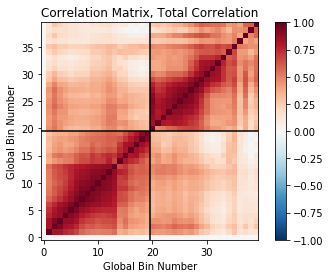

In [14]:
# first get correlations
corr = getCorrelations(total_cov, debug=False)
plotCorr(corr, [20,20], "Total Correlation")